In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle


# Train data analysis

In [10]:
train_data = dict()

envs = ['halfcheetah', 'hopper', 'walker2d']
datasets = ['expert', 'medium_replay', 'medium']
data_features = ['observations', 'next_observations', 'actions', 'rewards', 'terminals']

for e in envs:
    for d in datasets:
        with open(f'gym\\data\\{e}-{d}-v2.pkl', 'rb') as f:
            train_data[f'{e}-{d}'] = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '.\\gym\\data\\halfcheetah-expert-v2.pkl'

In [3]:
def concatenate_dataset(dataset):
    keys = list(dataset[0].keys())

    total_dict = dict()
    for key in keys:
        total_dict[key] = dataset[0][key]

    for traj in dataset[1:]:
        for key in keys:
            total_dict[key] = np.append(total_dict[key], traj[key], axis=0)
    
    return total_dict

concatenated_train_data = {k: concatenate_dataset(v) for k, v in train_data.items()}


In [ ]:
from sklearn.linear_model import LinearRegression

def get_coef(data_temp):
    forward_reward = data_temp['observations'][:,5]
    ctrl_cost = (data_temp['actions'] ** 2).sum(axis=1)
    healthy_reward = np.array(~data_temp['terminals'], dtype=int)

    target_reward = data_temp['rewards']


    X = np.stack((forward_reward, ctrl_cost, healthy_reward), axis=0).T

    reg = LinearRegression().fit(X, target_reward)

    r_score = reg.score(X, target_reward)
    
    return reg.coef_, r_score # (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score

In [ ]:
idxs = [f'{e}-{d}' for e in envs for d in datasets]
df_train_data = pd.DataFrame(index=idxs)

df_train_data['mean_terminals'] = [np.mean([sum(data['terminals']) for data in train_data[idx]]) for idx in idxs]
df_train_data['mean_terminal_reward'] = [np.mean([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['std_terminal_reward'] = [np.std([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['n_traj'] = [len(train_data[idx]) for idx in idxs]

df_train_data

,mean_terminals,mean_terminal_reward,std_terminal_reward,n_traj
halfcheetah-expert,0.000000,10656.426460,441.682728,1000
halfcheetah-medium_replay,0.000000,3093.285581,1680.693937,202
halfcheetah-medium,0.000000,4770.334765,355.750394,1000
hopper-expert,0.086660,3511.357707,328.585955,1027
hopper-medium_replay,0.803038,467.302044,511.025583,2041
hopper-medium,0.999543,1422.056180,378.953696,2186
walker2d-expert,0.001000,4920.507113,136.394925,1000
walker2d-medium_replay,0.723696,682.701247,895.955582,1093
walker2d-medium,0.431092,2852.088416,1095.443313,1190


In [ ]:
forward_reward_weights, ctrl_cost_weights, healthy_rewards, r_scores = [], [], [], []

for idx in idxs:
    e, d = idx.split('-')
    total_dict = concatenated_train_data[idx]

    if e == 'hopper':
        (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score = get_coef(total_dict)

        forward_reward_weights.append(forward_reward_weight)
        ctrl_cost_weights.append(ctrl_cost_weight)
        healthy_rewards.append(healthy_reward)
        r_scores.append(r_score)
    else:
        forward_reward_weights.append(0)
        ctrl_cost_weights.append(0)
        healthy_rewards.append(0)
        r_scores.append(0)

df_train_data['forward_reward_weight'] = forward_reward_weights
df_train_data['ctrl_cost_weight'] = ctrl_cost_weights
df_train_data['healthy_reward'] = healthy_rewards
df_train_data['r_score'] = r_scores

In [ ]:
print(df_train_data)

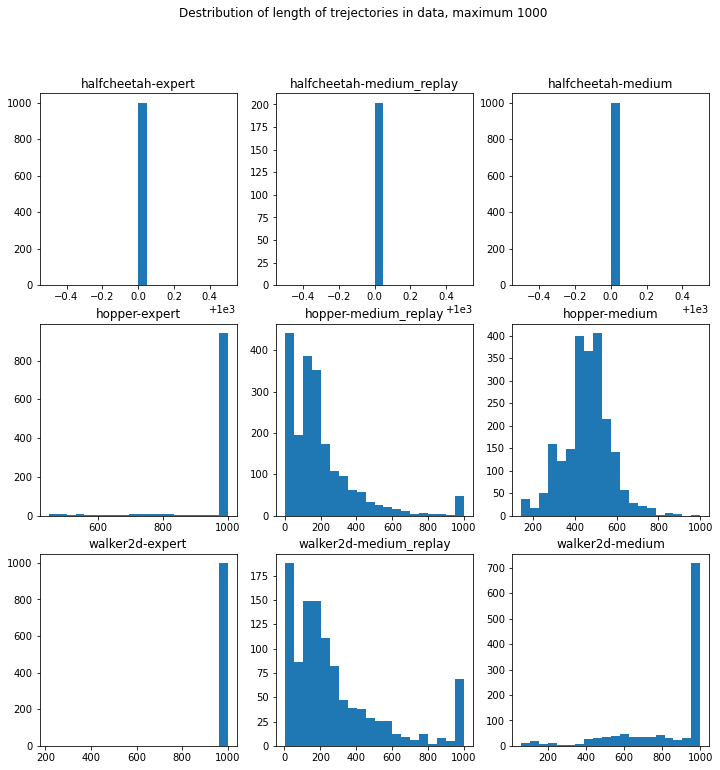

In [71]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12)) # note that halfcheetah does not terminate early, has no "survive" feature
fig.suptitle('Destribution of length of trejectories in data, maximum 1000')

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    lengths = [len(data['rewards']) for data in train_data[key]]
    ax.set_title(key)
    ax.hist(lengths, bins=20)

plt.show()

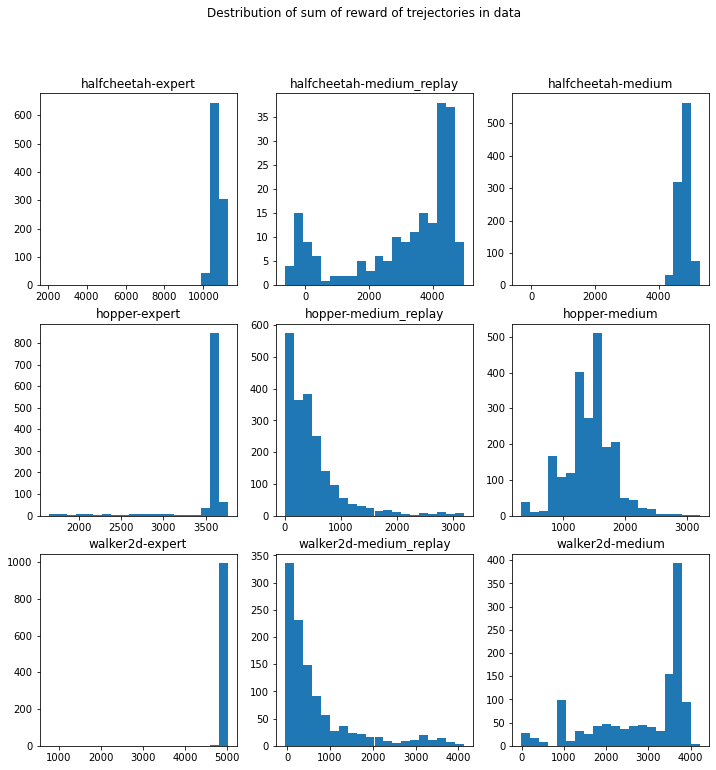

In [65]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Destribution of sum of reward of trejectories in data')

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    terminal_rewards = [sum(data['rewards']) for data in train_data[key]]
    ax.set_title(key)
    ax.hist(terminal_rewards, bins=20)

plt.show()

# Evaluation analysis

In [29]:
eval_path = './evaluation_data/'


raw_eval_dict = dict()

for env in os.listdir(eval_path):
    
    eval_path += env
    for dataset in os.listdir(eval_path):
        
        eval_path += dataset
        for filename in os.listdir(eval_path):
            with open(eval_path + filename, 'rb') as f:
                raw_eval_dict[filename] = pickle.load(f)

In [32]:
def read_data_to_DataFrama(raw_dict):

    return_keys = [key for key in raw_dict.keys() if '_returns' in key]
    temp_dict = dict()
    for key in return_keys:
        target_return, _ = key.split('_')
        target_return = int(target_return)
        temp_dict[target_return] = raw_dict[key]
    
    return pd.DataFrame(temp_dict)

eval_dict = {k: read_data_to_DataFrama(v) for k, v in raw_eval_dict.items()}

In [43]:
def get_plot_statistics(df):
    
    target_rewards = df.columns.to_numpy()
    reward_mean = df.to_numpy().mean(axis=0)
    reward_std = df.to_numpy().std(axis=0)

    return target_rewards, reward_mean, reward_std

plot_dict = {k: get_plot_statistics(v) for k, v in eval_dict.items()}

In [68]:
my_dict = {0: 10, 1: 11, 2: 22}
my_list = [5, 55, 555]

for x in zip(my_list, my_dict.items()):
    print(x)

(5, (0, 10))
(55, (1, 11))
(555, (2, 22))


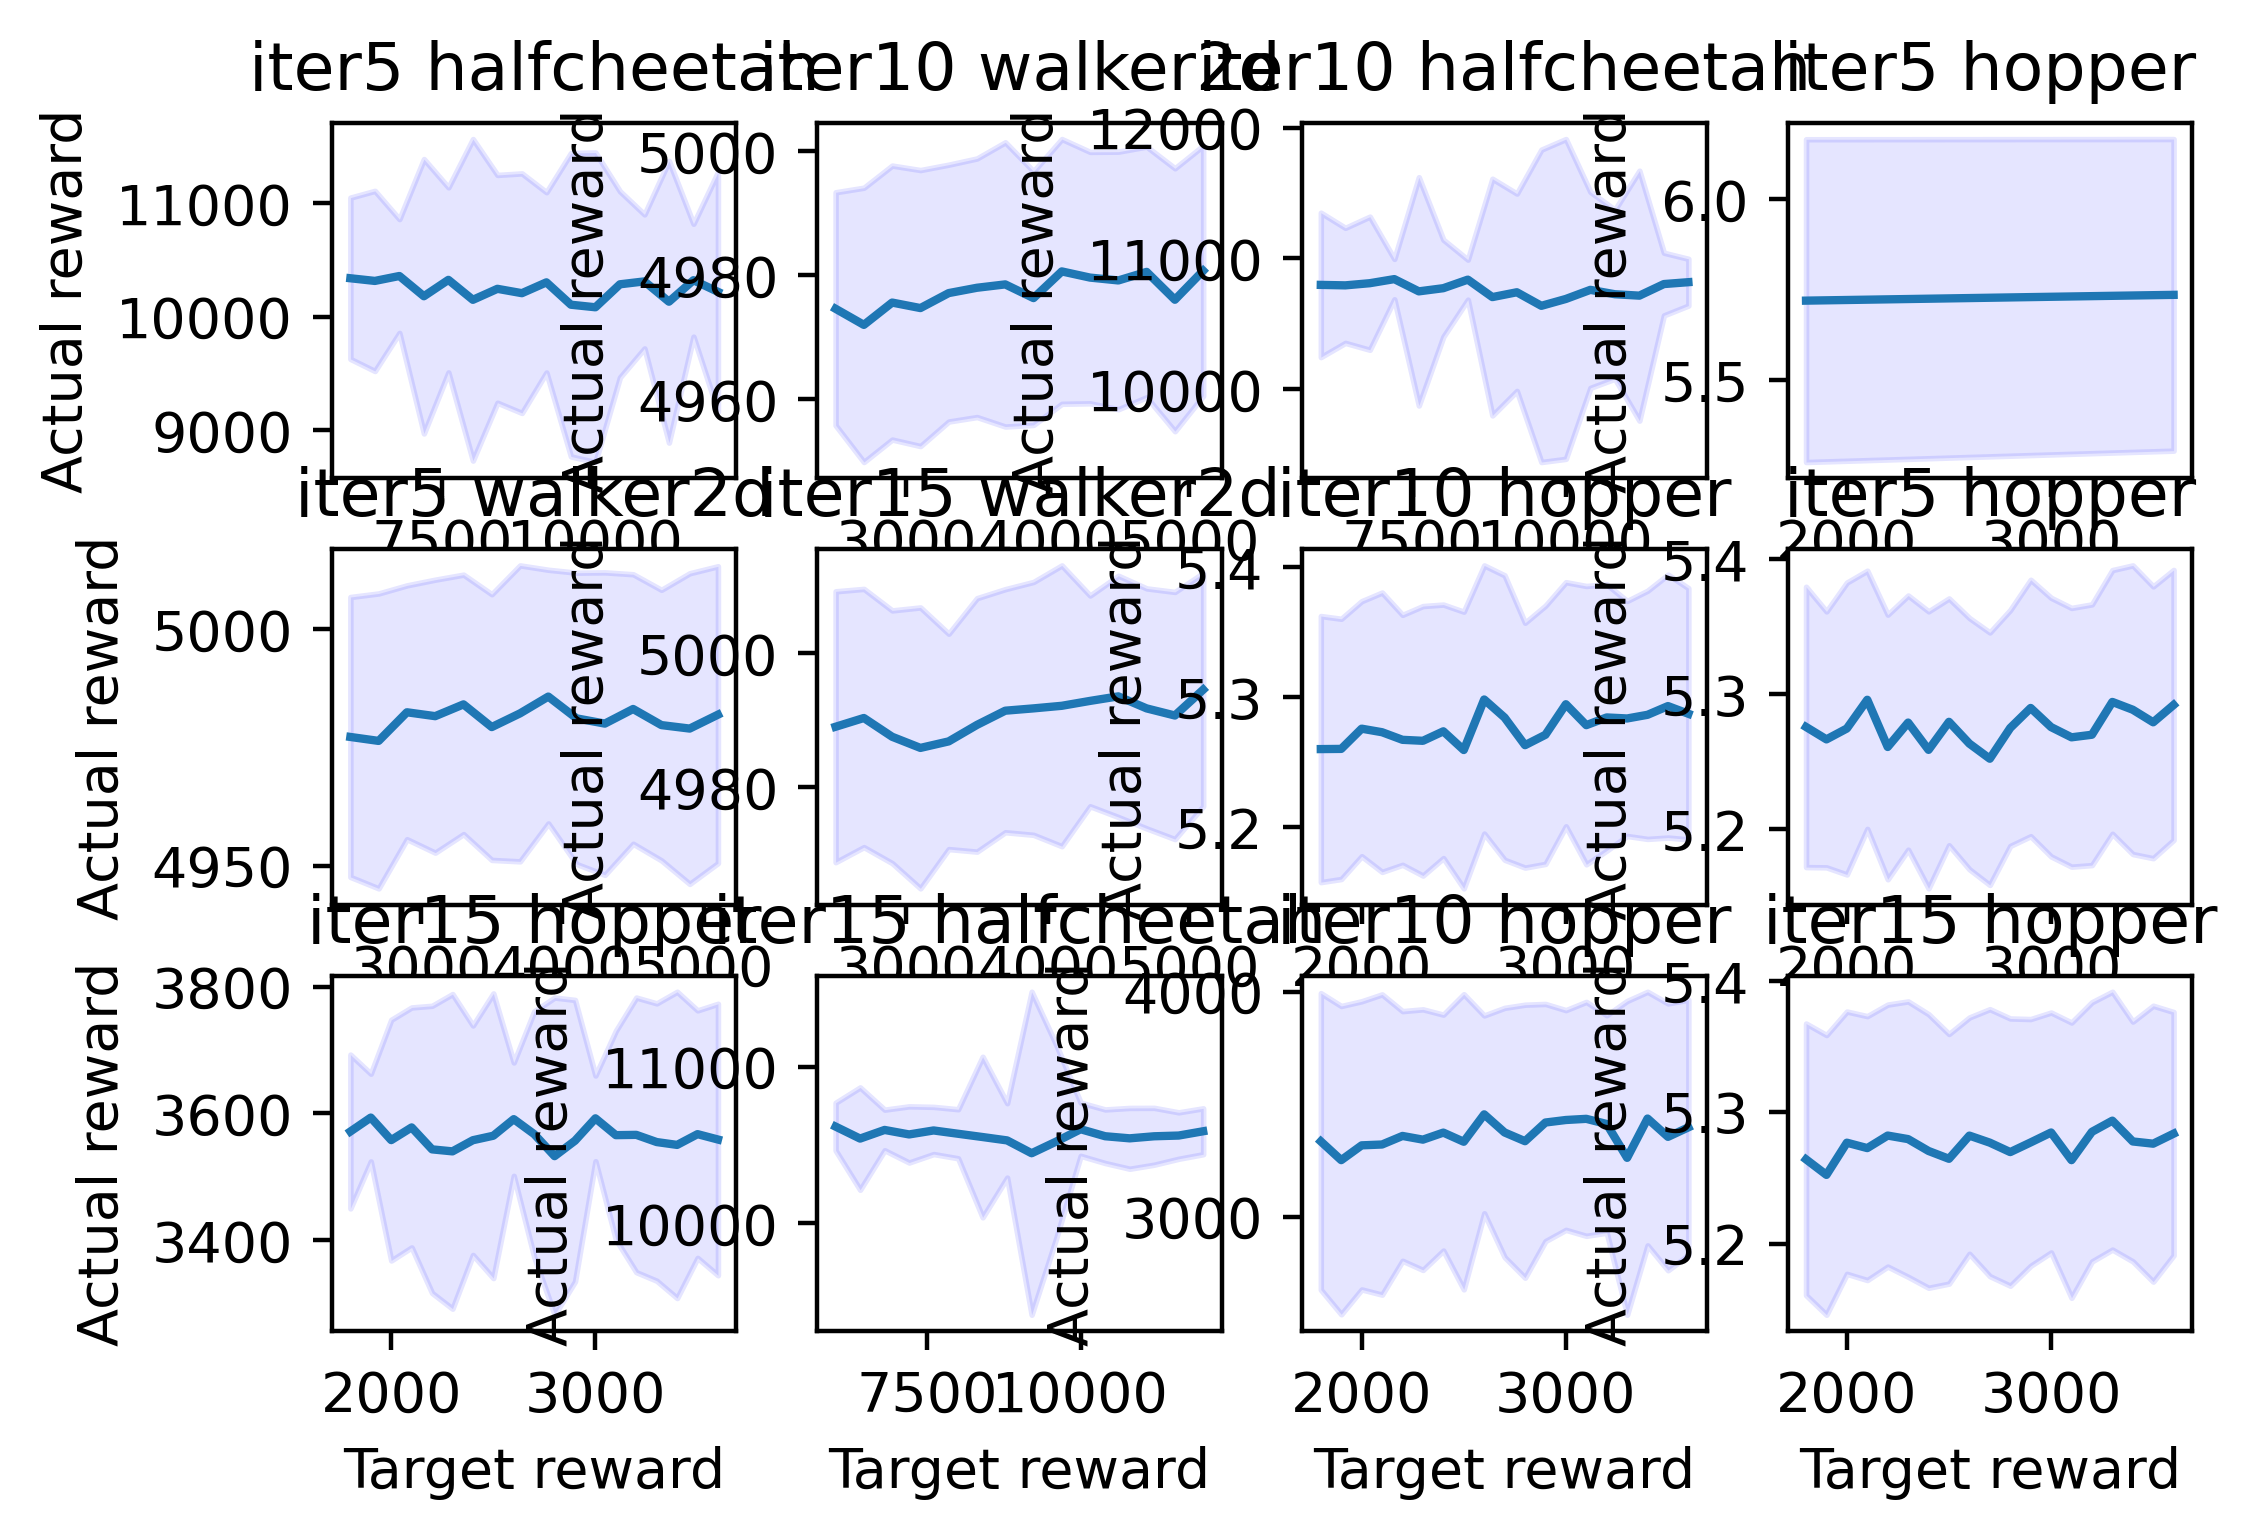

In [77]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
fig, axs = plt.subplots(3, 4, figsize=(12,12))

for ax, (exp_name, values) in zip(axs.flatten(), plot_dict.items()):
    x, y, ci = values

    ax.plot(x, y)
    ax.set_title(' '.join(np.take(exp_name.split('-'), (0,3))))
    ax.set_xlabel('Target reward')
    ax.set_ylabel('Actual reward')
    ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    #make_axes_area_auto_adjustable(ax)

plt.show()